## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/update-neural-network-models-with-more-data/)) <font size='3ptx'>**Deep learning neural network models used for predictive modeling may need to be updated.**</font>

This may be because the data has changed since the model was developed and deployed, or it may be the case that additional labeled data has been made available since the model was developed and it is expected that the additional data will improve the performance of the model.

It is important to experiment and evaluate with a range of different approaches when updating neural network models for new data, especially if model updating will be automated, such as on a periodic schedule.

There are many ways to update neural network models, although the two main approaches involve either using the existing model as a starting point and retraining it, or leaving the existing model unchanged and combining the predictions from the existing model with a new model.

**In this tutorial, you will discover how to update deep learning neural network models in response to new data.**

After completing this tutorial, you will know:
* Neural network models may need to be updated when the underlying data changes or when new labeled data is made available.
* How to update trained neural network models with just new data or combinations of old and new data.
* How to create an ensemble of existing and new models trained on just new data or combinations of old and new data.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into three parts; they are:
* <font size='3ptx'>[**Updating Neural Network Models**](#sect1)</font>
* <font size='3ptx'>[**Retraining Update Strategies**](#sect2)</font>
    * [**Update Model on New Data Only**](#sect2_1)
    * [**Update Model on Old and New Data**](#sect2_2)
* <font size='3ptx'>[**Ensemble Update Strategies**](#sect3)</font>
    * [**Ensemble Model With Model on New Data Only**](#sect3_1)
    * [**Ensemble Model With Model on Old and New Data**](#sect3_2)

<a id='sect1'></a>
## <font color='darkblue'>Updating Neural Network Models</font>
**Selecting and finalizing a deep learning neural network model for a predictive modeling project is just the beginning.** You can then start using the model to make predictions on new data.

One possible problem that you may encounter is that the nature of the prediction problem may change over time.

**You may notice this by the fact that the effectiveness of predictions may begin to decline over time. This may be because the assumptions made and captured in the model are changing or no longer hold.**

Generally, this is referred to as the problem of “**<font color='darkblue'>concept drift</font>**” where the underlying probability distributions of variables and relationships between variables change over time, which can negatively impact the model built from the data.

For more on **<font color='darkblue'>concept drift</font>**, see the tutorial:
* [A Gentle Introduction to Concept Drift in Machine Learning](https://machinelearningmastery.com/gentle-introduction-concept-drift-machine-learning/)

Concept drift may affect your model at different times and depends specifically on the prediction problem you are solving and the model chosen to address it. **It can be helpful to monitor the performance of a model over time and use a clear drop in model performance as a trigger to make a change to your model, such as re-training it on new data.**

Alternately, you may know that data in your domain changes frequently enough that a change to the model is required periodically, such as weekly, monthly, or annually. **Finally, you may operate your model for a while and accumulate additional data with known outcomes that you wish to use to update your model, with the hopes of improving predictive performance.**

Importantly, you have a lot of flexibility when it comes to responding to a change to the problem or the availability of new data.

For example, you can take the trained neural network model and update the model weights using the new data. Or we might want to leave the existing model untouched and combine its predictions with a new model fit on the newly available data.

These approaches might represent two general themes in updating neural network models in response to new data, they are:
* Retrain Update Strategies.
* Ensemble Update Strategies.

<a id='sect2'></a>
## <font color='darkblue'>Retraining Update Strategies</font>
**A benefit of neural network models is that their weights can be updated at any time with continued training.**

When responding to changes in the underlying data or the availability of new data, there are a few different strategies to choose from when updating a neural network model, such as:
* Continue training the model on the new data only.
* Continue training the model on the old and new data.

We might also imagine variations on the above strategies, such as using a sample of the new data or a sample of new and old data instead of all available data, as well as possible instance-based weightings on sampled data.

We might also consider extensions of the model that freeze the layers of the existing model (<font color='brown'>e.g. so model weights cannot change during training</font>), then add new layers with model weights that can change, grafting on extensions to the model to handle any change in the data. Perhaps this is a variation of the retraining and the ensemble approach in the next section, and we’ll leave it for now.

Nevertheless, these are the two main strategies to consider. Let’s make these approaches concrete with a worked example.

<a id='sect2_1'></a>
### <font color='darkgreen'>Update Model on New Data Only</font>
**We can update the model on the new data only.**

One extreme version of this approach is to not use any new data and simply re-train the model on the old data. This might be the same as “do nothing” in response to the new data. At the other extreme, a model could be fit on the new data only, discarding the old data and old model.
* Ignore new data, do nothing.
* Update existing model on new data.
* Fit new model on new data, discard old model and data.

We will focus on the middle ground in this example, but it might be interesting to test all three approaches on your problem and see what works best. **First, we can define a synthetic binary classification dataset and split it into half, then use one portion as “old data” and another portion as “new data.”**

In [61]:
# update neural network with new data only
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def calc_pr(old_model, X_test, y_test, new_model=None):
    plt.rcParams['figure.figsize'] = [9, 6]
    y_pred_old = old_model.predict(X_test).ravel()
    fpr_old, tpr_old, thresholds_old = roc_curve(y_test, y_pred_old)
    auc_old = auc(fpr_old, tpr_old)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_old, tpr_old, label='Old (area = {:.3f})'.format(auc_old))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    
    # Zoom in view of the upper left corner.
    if new_model:
        y_pred_new = new_model.predict(X_test).ravel()
        fpr_new, tpr_new, thresholds_new = roc_curve(y_test, y_pred_new)
        auc_keras = auc(fpr_new, tpr_new)
        plt.plot(fpr_keras, tpr_keras, label='New (area = {:.3f})'.format(auc_keras))
        
    plt.show()

In [58]:
# feature size
n_features = 20
n_samples = 2000
serialized_model_path = 'mymodel'

def get_data(random_state=1, n_new_samples=0):
    # define dataset
    X, y = make_classification(
        n_samples=n_samples, 
        n_features=n_features,
        n_informative=15,
        n_redundant=5,
        random_state=random_state
    )

    # split into old and new data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=1)
    X_old, X_new, y_old, y_new = train_test_split(X_train, y_train, test_size=0.50, random_state=1)
    
    if n_new_samples > 0:
        _X, _y = make_classification(
            n_samples=n_new_samples, 
            n_features=n_features,
            n_informative=16,
            n_redundant=4,
            random_state=random_state+1
        )
        
        _X_train, _X_test, _y_train, _y_test = train_test_split(_X, _y, test_size=0.80, random_state=1)
        y_new = np.hstack((y_new, _y_train))
        y_test = np.hstack((y_test, _y_test))
        X_new = np.vstack((X_new, _X_train))
        X_test = np.vstack((X_test, _X_test))
    
    return X_old, X_new, X_test, y_old, y_new, y_test

X_old, X_new, X_test, y_old, y_new, y_test = get_data()

In [43]:
# define the model
def get_model():
    model = Sequential()
    model.add(Dense(20, kernel_initializer='he_normal', activation='relu', input_dim=n_features))
    model.add(Dense(10, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# define the optimization algorithm
opt = SGD(learning_rate=0.01, momentum=0.9)

# compile the model
model = get_model()
model.compile(optimizer=opt, loss='binary_crossentropy')

# fit the model on old data
model.fit(X_old, y_old, epochs=150, batch_size=32, verbose=0)

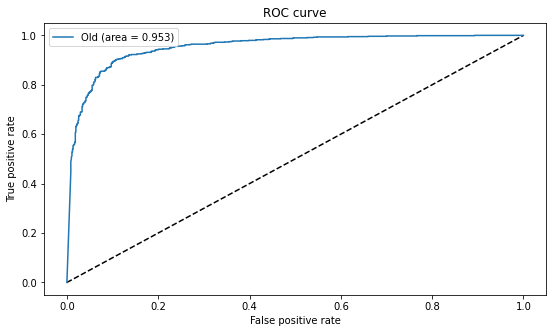

In [44]:
calc_pr(model, X_test, y_test)

In [45]:
# save model
# https://www.tensorflow.org/guide/keras/save_and_serialize
model.save(serialized_model_path)

INFO:tensorflow:Assets written to: mymodel\assets


In [46]:
# update model on new data only with a smaller learning rate
opt = SGD(learning_rate=0.001, momentum=0.9)

# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy')

# fit the model on new data
model.fit(X_new, y_new, epochs=100, batch_size=32, verbose=0)

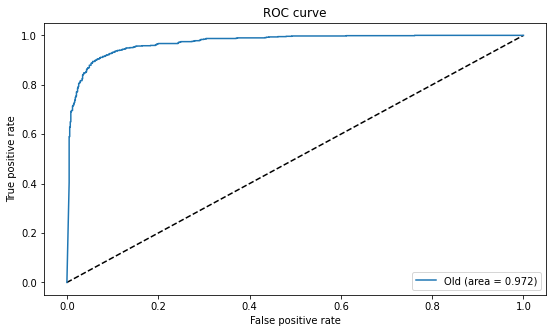

In [47]:
calc_pr(model, X_test, y_test)

With new data, The AUC of model is improved from 0.953 to 0.972. Next, let’s look at updating the model on new and old data.

<a id='sect2_2'></a>
### <font color='darkgreen'>Update Model on Old and New Data</font>
**We can update the model on a combination of both old and new data.**

An extreme version of this approach is to discard the model and simply fit a new model on all available data, new and old. A less extreme version would be to use the existing model as a starting point and update it based on the combined dataset.

Again, **it is a good idea to test both strategies and see what works well for your dataset**. We will focus on the less extreme update strategy in this case.

The synthetic dataset and model can be fit on the old dataset as before.

In [49]:
# define dataset
X_old, X_new, X_test, y_old, y_new, y_test = get_data()

# define the model
model = get_model()

# define the optimization algorithm
opt = SGD(learning_rate=0.01, momentum=0.9)

# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy')

# fit the model on old data
model.fit(X_old, y_old, epochs=150, batch_size=32, verbose=0)

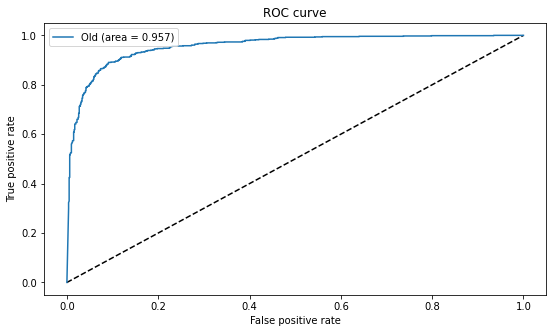

In [50]:
calc_pr(model, X_test, y_test)

New data comes available and we wish to **update the model on a combination of both old and new data.**

First, we **must use a much smaller learning rate in an attempt to use the current weights as a starting point for the search.**
> <font color='darkred'>**Note:**</font> you will need to discover a learning rate that is appropriate for your model and dataset that achieves better performance than simply fitting a new model from scratch.

In [51]:
# update model with a smaller learning rate
opt = SGD(learning_rate=0.001, momentum=0.9)

# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy')

We can then create a composite dataset composed of old and new data.

In [52]:
# create a composite dataset of old and new data
X_both, y_both = np.vstack((X_old, X_new)), np.hstack((y_old, y_new))

Finally, we can update the model on this composite dataset.

In [53]:
# fit the model on new data
model.fit(X_both, y_both, epochs=100, batch_size=32, verbose=0)

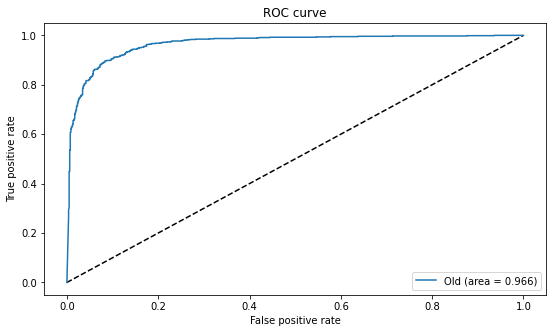

In [54]:
calc_pr(model, X_test, y_test)

With both old+new data, The AUC of model is improved from 0.957 to 0.966. Next, let’s look at how to use ensemble models to respond to new data.

<a id='sect3'></a>
## <font color='darkblue'>Ensemble Update Strategies</font>
**An ensemble is a predictive model that is composed of multiple other models.**

There are many different types of ensemble models, although perhaps the simplest approach is to average the predictions from multiple different models. For more on ensemble algorithms for deep learning neural networks, see the tutorial:
* [Ensemble Learning Methods for Deep Learning Neural Networks](https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/)

We can use an ensemble model as a strategy when responding to changes in the underlying data or availability of new data. Mirroring the approaches in the previous section, we might consider **two approaches to ensemble learning algorithms as strategies for responding to new data; they are**:
* Ensemble of existing model and new model fit on new data only.
* Ensemble of existing model and new model fit on old and new data.

Again, we might consider variations on these approaches, such as samples of old and new data, and more than one existing or additional models included in the ensemble. Nevertheless, these are the two main strategies to consider.

Let’s make these approaches concrete with a worked example.

<a id='sect3_1'></a>
### <font color='darkgreen'>Ensemble Model With Model on New Data Only</font>
**We can create an ensemble of the existing model and a new model fit on only the new data.**

The expectation is that the ensemble predictions perform better or are more stable (<font color='brown'>lower variance</font>) than using either the old model or the new model alone. This should be checked on your dataset before adopting the ensemble.

First, we can prepare the dataset and fit the old model, as we did in the previous sections.

In [59]:
# define dataset
X_old, X_new, X_test, y_old, y_new, y_test = get_data(n_new_samples=200)

# define the model
model = get_model()

# define the optimization algorithm
opt = SGD(learning_rate=0.01, momentum=0.9)

# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy')

# fit the model on old data
model.fit(X_old, y_old, epochs=150, batch_size=32, verbose=0)

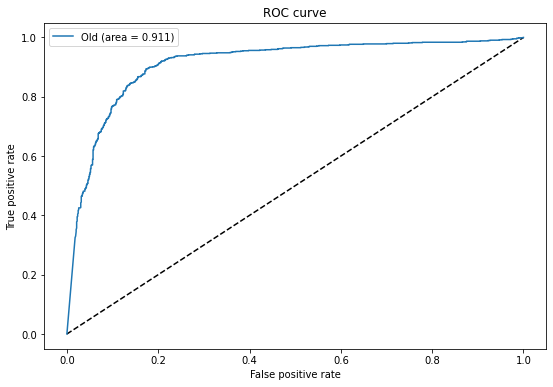

In [62]:
calc_pr(model, X_test, y_test)

Some time passes and new data becomes available. We can then fit a new model on the new data, **naturally discovering a model and configuration that works well or best on the new dataset only.**

In this case, we’ll simply use the same model architecture and configuration as the old model.

In [63]:
# define the model
new_model = get_model()

# define the optimization algorithm
opt = SGD(learning_rate=0.01, momentum=0.9)

# compile the model
new_model.compile(optimizer=opt, loss='binary_crossentropy')

We can then fit this new model on the new data only.

In [64]:
# fit the model on old data
new_model.fit(X_new, y_new, epochs=150, batch_size=32, verbose=0)

Now that we have the two models, we can make predictions with each model, and calculate the average of the predictions as the “ensemble prediction.”

In [76]:
class EnsembleAvg:
    def __init__(self, *models):
        self.models = models
        
    def predict(self, X):
        yhat = self.models[0].predict(X)
        for m in self.models[1:]:
            y = m.predict(X)
            yhat = np.hstack((yhat, y))
            
        yhat = np.mean(yhat, axis=-1)
        return yhat

In [78]:
ea = EnsembleAvg(model, new_model)

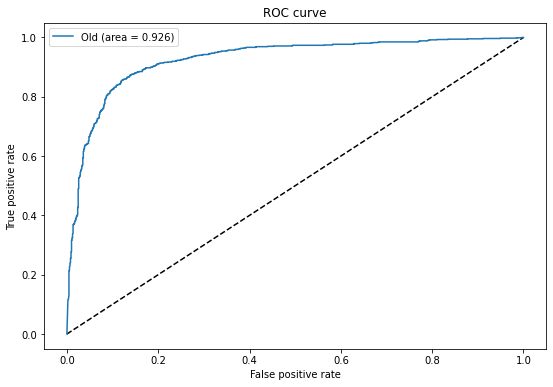

In [79]:
calc_pr(ea, X_test, y_test)

With ensemble model, The AUC of model is improved from 0.911 to 0.926. 

<a id='sect3_2'></a>
### <font color='darkgreen'>Ensemble Model With Model on Old and New Data</font>
**We can create an ensemble of the existing model and a new model fit on both the old and the new data.**

The expectation is that the ensemble predictions perform better or are more stable (<font color='brown'>lower variance</font>) than using either the old model or the new model alone. This should be checked on your dataset before adopting the ensemble.

First, we can prepare the dataset and fit the old model, as we did in the previous sections.

In [80]:
# define dataset
X_old, X_new, X_test, y_old, y_new, y_test = get_data(n_new_samples=500)

# define the model
model = get_model()

# define the optimization algorithm
opt = SGD(learning_rate=0.01, momentum=0.9)

# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy')

# fit the model on old data
model.fit(X_old, y_old, epochs=150, batch_size=32, verbose=0)

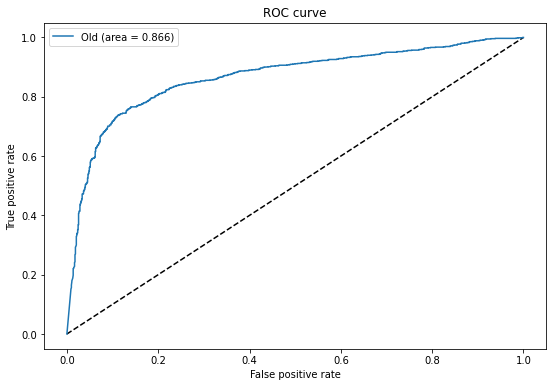

In [81]:
calc_pr(model, X_test, y_test)

We can then fit a new model on a composite of the old and new data. In this case, we’ll simply use the same model architecture and configuration as the old model:

In [82]:
# define the model
new_model = get_model()

# define the optimization algorithm
opt = SGD(learning_rate=0.01, momentum=0.9)

# compile the model
new_model.compile(optimizer=opt, loss='binary_crossentropy')

We can create a composite dataset from the old and new data, then fit the new model on this dataset.

In [84]:
# create a composite dataset of old and new data
X_both, y_both = np.vstack((X_old, X_new)), np.hstack((y_old, y_new))

# fit the model on old data
new_model.fit(X_both, y_both, epochs=150, batch_size=32, verbose=0)

Finally, we can use both models together to make ensemble predictions.

In [85]:
ea = EnsembleAvg(model, new_model)

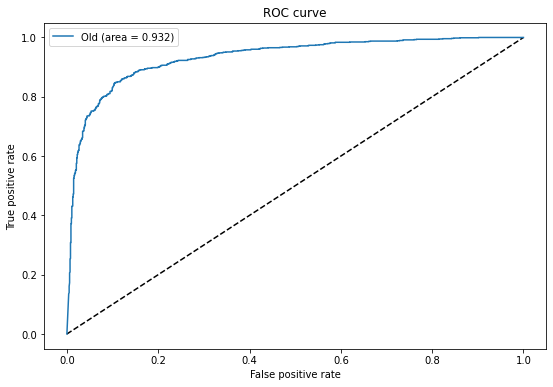

In [86]:
calc_pr(ea, X_test, y_test)

With ensemble model, The AUC of model is improved from 0.866 to 0.932.

## <font color='darkblue'>Summary</font>
In this tutorial, you discovered how to update deep learning neural network models in response to new data. Specifically, you learned:
* Neural network models may need to be updated when the underlying data changes or when new labeled data is made available.
* How to update trained neural network models with just new data or combinations of old and new data.
* How to create an ensemble of existing and new models trained on just new data or combinations of old and new data.

## <font color='darkblue'>Supplement</font>
* [Various ways to evaluate a machine learning model’s performance](https://towardsdatascience.com/various-ways-to-evaluate-a-machine-learning-models-performance-230449055f15)
* [Simple guide on how to generate ROC plot for Keras classifier](https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/)